In [1]:
from tensorflow.keras.models import load_model

from matplotlib import pyplot as plt
import numpy as np
import cv2

from src import dataset

(175, 273, 28, 28)


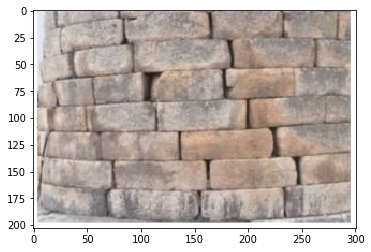

In [87]:
# 위 코드에 이어서...

frame = list(dataset.tmp_load())[0][1]
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def cut_all_possible_image(src, ksize):
    k_height, k_width = ksize
    im_height, im_width = src.shape[:2]
    
    ret_height = im_height - k_height
    ret_width = im_width - k_width

    retval = np.zeros((ret_height, ret_width, k_height, k_width), dtype=np.uint8)
    for x in range(ret_width):
        for y in range(ret_height):
            retval[y,x,:k_height,:k_width] = src[y:y+k_height, x:x+k_width].copy()
    return retval

x_map = cut_all_possible_image(frame_gray, (28,28))

print(x_map.shape)

plt.imshow(frame_rgb)
plt.show()

In [76]:
# 위 코드에 이어서...

model = load_model('model/v0_softmax16')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0

In [77]:
(x_train, y_train), (x_test, y_test) = dataset.load()


x_train = np.reshape(x_train / 255.0, tuple([x_train.shape[0]] + list(model.input_shape)[1:]))
x_test  = np.reshape(x_test  / 255.0, tuple([x_test.shape[0]]  + list(model.input_shape)[1:]))

# model.fit(x_train, y_train, epochs=4)
model.evaluate(x_test, y_test)


* random_seed: 0
* train: 830 samples
    label-0(normal): 576
    label-1(broken): 254
* test: 207 samples
    label-0(normal): 134
    label-1(broken): 73

207/207 [==============================] - 0s 950us/sample - loss: 0.5277 - accuracy: 0.8357


[0.52768599047609, 0.8357488]

In [70]:
# 위 코드에 이어서...

h,w = x_map.shape[:2]

new_shape = tuple([h*w] + list(model.input_shape[1:]))

x_flattened = np.reshape(x_map / 255.0, new_shape)

print(x_flattened.shape)

(47775, 28, 28, 1)


In [78]:
# 위 코드에 이어서...

y_flattened = model.predict(x_flattened)

print(f"""Summary:
shape: {y_flattened.shape}
ratio: {np.sum(y_flattened[:,0]) / np.sum(y_flattened[:,1]):.2f}
       ({np.sum(y_flattened[:,0]):.2f}/{np.sum(y_flattened[:,1]):.2f})

avg: {np.average(y_flattened)} / var: {np.var(y_flattened)}
max: {np.max(y_flattened)} / min: {np.min(y_flattened)}
""")

Summary:
shape: (47775, 2)
ratio: 27.19
       (6135.35/225.61)

avg: 0.06657205522060394 / var: 0.008174022659659386
max: 0.3949834406375885 / min: 1.1017088574760692e-08



In [96]:
y_map = y_flattened[:,1].copy()
y_map *= 255
y_map = y_map.astype(np.uint8)
y_map = y_map.reshape(h,w)

print(f"""
max: {np.max(y_map)} / min: {np.min(y_map)}
""")

print(y_map)


max: 41 / min: 0

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


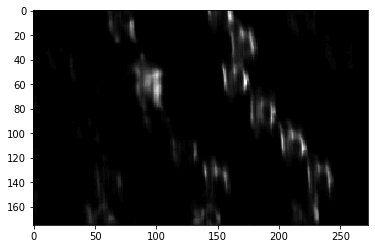

In [97]:
plt.imshow(y_map, cmap='gray')
plt.show()

(203, 301, 3) uint8


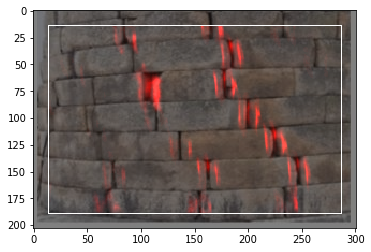

In [112]:
h,w = y_map.shape[:2]

frame_out = np.zeros(frame_rgb.shape, dtype=np.uint8)

for y in range(h):
    for x in range(w):
        frame_out[y+14,x+14] = (y_map[y,x], 0, 0)

print(frame_rgb.shape, frame_rgb.dtype)


h,w = frame_rgb.shape[:2]
cv2.rectangle(frame_out, (14,14), (w-14, h-14), (255,255,255), 1)

fig, axs = plt.subplots(1,2, figsize=(20,8))

axs[0].imshow(frame_rgb)
axs[1].imshow(cv2.addWeighted(frame_rgb, 0.5, frame_out, 8, 0))

plt.show()